In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.linear_model import LinearRegression


In [3]:
import scipy.optimize as opt
import pint
from sklearn.metrics import r2_score

reading the file: 4 colnames: Date & Time; Pressure (psig); Pressure (VDC); Excitation (VDC)

In [4]:
def load_raw_data(filename, verbose = False):
    '''Read csv file of measurement, including time,pressure, temperature etc. 
        convert time into second
        
    Args:
        filename: str(), the filename(*.csv) that needed to be read 
        verbose: bool(), print out description if True
        
    Returns:
        t: 1d np.array, time in raw measurement, with unit of second
        p: 1d np.array, pressure in raw measurement, with unit of psia (absolute psi) 
        
    '''
    df_raw = pd.read_csv(filename, header = 1, usecols=range(3)) 
    if verbose:
        print('basic file info')
        print(df_raw.info())

    df_raw['time'] = df_raw['Date & Time'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M:%S.%f'))
    df_raw = df_raw.groupby(['time'], axis=0, as_index=False).mean()
    df_raw['time_sec']= df_raw['time'].apply(lambda x: (x-df_raw['time'].iloc[0]).total_seconds())# convert to sec
    t = df_raw['time_sec'].values
    p = df_raw['Pressure (psia)'].values
    
    if verbose:
        print('return t(time in sec) and p(pressure in psig)')
    return t, p

def load_sample_info(filename, billets_use = [5], verbose = False):
    '''Read excel file to get sample mass/density, get cells volume, get billets volume
        calculate sample mass, bulk volume, dead space of reference and sample cells
    Args:
        filename: str(), the filename(*.csv) that needed to be read
        billets_use: list(), the list of billet number in used
        verbose: bool(), print out description if True 
    
    Returns:
        V_dead_refer: float, the dead volume of reference cell , with unit of cm^3
        V_dead_sample: float, the dead volume of sample cell = total cell - billets volume - sample bulk volume
            with unit of cm^3
        V_bulk: float, the bulk volume of the sample. 
        
    '''
    df_sample = pd.read_excel(filename, sheetname='sample')
    M_cell_empty = df_sample['Mass_empty_cell'].loc[0]
    M_cell_full = df_sample['Mass_sample_cell'].loc[0]
    den_sample = df_sample['sample_density(cm^3/g)'].loc[0]
    M_sample = M_cell_full  - M_cell_empty
    V_bulk = M_sample/den_sample # bulk volume 
    
    df_billets = pd.read_excel(filename, sheetname = 'billets')
    No_billets = list(df_billets['No'].values) 
    V_billets = list(df_billets['volume(cm^3)'].values)
    V_billets_use = [V_billets[i] for i,e in enumerate(No_billets) if e in billets_use] 
    V_billets_total = np.sum(V_billets_use) # total volume of billets in use
    #V_billets_total # return

    df_cell = pd.read_excel(filename, sheetname = 'cell')
    V_sample_cell_empty = df_cell[df_cell['cell_name'] =='sample_cell']['Volume(cm^3)'].values[0] # return 
    V_refer_cell = df_cell[df_cell['cell_name'] =='reference_cell']['Volume(cm^3)'].values[0] # return
    
    # calculate dead volume
    V_dead_sample = V_sample_cell_empty - V_billets_total #- V_bulk
    V_dead_refer = V_refer_cell 
    
    if verbose:
        print('return (dead volume of sample cell(cm^3) , dead volume of reference cell(cm^3) , bulk volume of sample(cm^3)')
    return V_dead_refer, V_dead_sample, V_bulk

def get_leak_rate(t_raw, p_raw, id_leak, verbose = False):
    '''Calculate leakage rate at late time, when leakage dominate the pressure decay
        use linear regression to get tate_leak by fitting pressure = intersect + rate_leak * time
    
    Args:
        t_raw: 1d np.array, time of raw measurement with unit of second, 
        p_raw: 1d np.array, pressure of raw measurement with unit of psi,
        id_leak, int, index of leak start to dominant, ususally choosing a late time
        
    Returns:
        rate_leak: float, the rate of leakage with unit of psi/sec
    '''
    delta_id = 19
    id_leak -=  delta_id # 5876
    linear_model = LinearRegression()
    linear_model.fit(t_raw[id_leak:].reshape(-1,1),p_raw[id_leak:].reshape(-1,1)) # convert to (n_row,1) matrix to fit
    rate_leak = linear_model.coef_[0][0]
    
    if verbose:
        print('rate of leak in unit (psi/sec)')
    return rate_leak

def get_three_pressure(t_raw, p_raw, id_leak = 5857, p_vaccum_max = 0.5, r_lowb_elevate = 0.033,
                      r_upb_decay  = 0.2, p_lowb_decay = 20, len_final_p = 19):
    '''Pick up three stage of the measurements using some criterion 
            - vaccum stage: pressure is low 
            - elevated stage: pressure is high
            - decay stage: pressure decay, final stage is the end of decay stage
        calcualte the average pressure at vaccum stage, elevated stage and final stage
        perform leakage correction for decay stage
        
    Args:
        t_raw: 1d np.array, time of raw measurement with unit of second, 
        p_raw: 1d np.array, pressure of raw measurement with unit of psi,
        id_leak, int, index of leak start to dominant, ususally choosing a late time
        p_vaccum_max: float, max value for pressure to be considered as vaccum stage
        r_lowb_elevate: float, between 0-1, lowerbound ratio, 
            p_raw > (1- r_lowb_elevate) * p_max to considered as elevate stage
        r_upb_decay: float, between 0-1, upperbound ratio
        p_lowb_decay: float, lowerbound of pressure; 
            (p_raw > p_lowb_decay) & (p_raw < p_elevate_mean*(1- r_upb_decay ) to be considered as decay stage
        len_final_p: int, > 0, the number of pressure points for averaging final pressure
    
    Returns:
        p_vaccum_mean: float, the mean of vaccum stage pressure, with unit of psi
        p_elevate_mean: float, the mean of elevate stage pressure, with unit of psi
        p_final_corr_mean: float, the mean of corrected final decay stage pressure, with unit of psi
        data_3stage: dict(), key = ['vaccum','elevate','decay']
        
    '''
    # ratio lower bound of
    # ratio upper bound of decay 
    #psi 
    # main function
    id_vaccum = p_raw < p_vaccum_max
    p_vaccum = p_raw[id_vaccum] # return
    t_vaccum = t_raw[id_vaccum] # return
    p_vaccum_mean = np.mean(p_vaccum) #return

    # elevated stage 
    p_max = max(p_raw)
    id_elevate = p_raw > (1- r_lowb_elevate) * p_max 
    p_elevate = p_raw[id_elevate]
    t_elevate = t_raw[id_elevate]
    p_elevate_mean = np.mean(p_elevate)

    # decay stage
    id_decay = (p_raw > p_lowb_decay) & (p_raw < p_elevate_mean*(1- r_upb_decay ))
    p_decay = p_raw[id_decay]
    t_decay = t_raw[id_decay]
    p_final_mean = np.mean(p_decay[len(p_decay)-len_final_p : len(p_decay)])

    rate_leak = get_leak_rate(t_raw, p_raw, id_leak)
    p_decay_corr = p_decay - rate_leak * t_decay 
    p_final_corr_mean = np.mean(p_decay_corr[len(p_decay_corr)-len_final_p : len(p_decay_corr)])
    
    p_history = {}
    p_history['vaccum'] = {}
    p_history['elevate'] = {}
    p_history['decay'] = {}
    
    p_history['vaccum']['p'] = p_vaccum
    p_history['vaccum']['t'] = t_vaccum
    p_history['elevate']['p'] = p_elevate
    p_history['elevate']['t'] = t_elevate
    p_history['decay']['p'] = p_decay
    p_history['decay']['p_corr'] = p_decay_corr
    p_history['decay']['t'] = t_decay
    
    #id_decay_start = np.where(id_elevate == True)[0][-1]+1 # end of elevate stage index + 1
    return p_vaccum_mean, p_elevate_mean, p_final_corr_mean, p_history 

def get_zfactor_from_p(p):
    '''Calcualte z factor with given p using polynomial function
        z function is determined by linear regression 
    Args:
        p: float, pressure with unit of psi
    
    Returns:
        z: z factor, no unit
        
    '''
    p_vector = np.array([1, p, p**2, p**3, p**4, p**5])
    theta = np.array([0.9999793782, 0.000031122396573, 1.9567389783E-10, 
                      - 3.5148991187E-14, 1.8413900717E-18, -3.9865334731E-23])
    z = theta.dot(p_vector.T)
    return z

def get_porosity(p_vaccum_mean, p_elevate_mean, p_final_corr_mean, V_dead_refer, V_dead_sample, V_bulk):
    '''Calculate porosity of using pulse-decay measurements
    
    Args:
        p_vaccum_mean: float, the mean of vaccum stage pressure, with unit of psi
        p_elevate_mean: float, the mean of elevate stage pressure, with unit of psi
        p_final_corr_mean: float, the mean of corrected final decay stage pressure, with unit of psi
        V_dead_refer: float, the dead volume of reference cell , with unit of cm^3
        V_dead_sample: float, the dead volume of sample cell = total cell - billets volume - sample bulk volume
            with unit of cm^3
        V_bulk: float, the bulk volume of the sample.
    
    Returns:
        porosity: porosity of the sample, with no unit
        
    '''
    
    z_vaccum_mean = get_zfactor_from_p(p_vaccum_mean)
    z_elevate_mean = get_zfactor_from_p(p_elevate_mean)
    z_final_corr_mean = get_zfactor_from_p(p_final_corr_mean)
    
    temp1 = V_dead_refer * (p_elevate_mean/z_elevate_mean - p_final_corr_mean/z_final_corr_mean) 
    temp2 = (V_dead_sample - V_bulk)*(p_vaccum_mean/z_vaccum_mean - p_final_corr_mean/z_final_corr_mean) 
    temp3 = V_bulk * (p_final_corr_mean/z_final_corr_mean - p_vaccum_mean/z_vaccum_mean)
    
    porosity = (temp1 + temp2)/temp3
    return porosity

In [5]:
def main_porosity():
    filename = 'HeP0203_raw.csv'
    t_raw, p_raw = load_raw_data(filename)
    filename =  'instru_info.xlsx'
    billets_use = [5]
    V_dead_refer, V_dead_sample, V_bulk = load_sample_info(filename, billets_use, verbose = False)
    p_vaccum_mean, p_elevate_mean, p_final_corr_mean,_ = get_three_pressure(t_raw, p_raw)
    porosity = get_porosity(p_vaccum_mean, p_elevate_mean, p_final_corr_mean, V_dead_refer, V_dead_sample, V_bulk)
    #porosity # porosity = 0.092287285753830967
    return porosity

In [6]:
filename = 'HeP0203_raw.csv'
t_raw, p_raw = load_raw_data(filename)
filename =  'instru_info.xlsx'
billets_use = [5]
V_dead_refer, V_dead_sample, V_bulk = load_sample_info(filename, billets_use, verbose = False)
p_vaccum_mean, p_elevate_mean, p_final_corr_mean, p_history = get_three_pressure(t_raw, p_raw)
porosity = get_porosity(p_vaccum_mean, p_elevate_mean, p_final_corr_mean, V_dead_refer, V_dead_sample, V_bulk)
porosity # porosity = 0.092287285753830967

0.092287285753830967

In [7]:
main_porosity()

0.092287285753830967

## start to calculate permeability

In [331]:
ureg = pint.UnitRegistry()


def get_density(press, z = 1):
    """
    Args:
        press: ureg type, 
    """
    press = press * ureg['psi']
    R_gas_constant = 8.314 * ureg['J/(mol*kelvin)']
    Temp = 303.15 * ureg['kelvin']
    Mass_molar = 4.0003* ureg['gram/mol']
    den = press * Mass_molar / (z * R_gas_constant * Temp)
    return den
#press = 1 * ureg['atm']



#Mass_molar = 28.97* ureg['gram/mol']
#R_specific = R_gas_constant / Mass_molar
#print(R_specific)
V_dead_cell = V_dead_refer +  V_dead_sample -  V_bulk
kc = (V_dead_cell) / (porosity * V_bulk)
#den.to_base_units() # the air is about 1 kg/m^3
den_elevate_mean = get_density(p_elevate_mean)
den_vaccum_mean = get_density(p_vaccum_mean)
den_final_corr_mean = get_density(p_final_corr_mean)
den_c0 = ( den_elevate_mean * V_dead_refer + den_vaccum_mean * (V_dead_sample - V_bulk)) / V_dead_cell 
den_c0= den_c0*0.975 # !!!!! special operation
#print()
p_decay_corr = p_history['decay']['p_corr'][50:]# psi
p_decay = p_history['decay']['p'][50:]
t_decay = p_history['decay']['t'][50:]
t_decay = t_decay - t_decay[0]# sec
den_decay_corr = get_density(p_decay_corr)
den_decay = get_density(p_decay)

In [332]:
FR_ = 1 - (kc+1)*(den_c0 - den_decay)/(den_c0 - den_vaccum_mean)
FR_corr = 1 - (kc+1)*(den_c0 - den_decay_corr)/(den_c0 - den_vaccum_mean)
#FR_final =  1 - (kc+1)*(den_c0 - den_final_corr_mean)/(den_c0 - den_vaccum_mean)
#FR =  

In [333]:
FR_final1 = V_bulk*(den_final_corr_mean - den_vaccum_mean) / (V_dead_refer*(den_elevate_mean - den_vaccum_mean))
FR_final1

<Quantity(0.4982077373523237, 'dimensionless')>

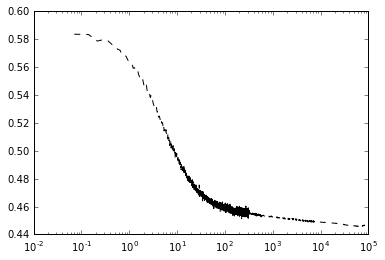

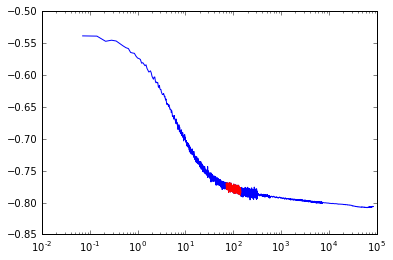

In [345]:
plt.figure()
#plt.semilogx(t_decay[20:],p_decay_corr[20:],'-')
#plt.semilogx(t_decay[20:], FR[20:])
#plt.semilogx(t_decay[20:], FR[20:])
plt.semilogx(t_decay[:], FR_corr[:],'k--')


plt.figure()
plt.semilogx(t_decay[:], np.log(FR_corr[:]))
plt.semilogx(t_decay[1000:2000], np.log(FR_corr[1000:2000]),'r-')
#plt.semilogx([10**2, 10**4],[FR_final, FR_final])
#plt.xlim([10**2,10**5])


In [349]:
#np.ln()
reg_model = LinearRegression()
x = t_decay[1000:2000].reshape(-1,1)
y_true = np.log(FR_corr[1000:2000].reshape(-1,1))

reg_model.fit(x,y_true)
slope = reg_model.coef_[0][0]
print(reg_model.score)
s1 = -slope
y_pred = reg_model.predict(x)
r2 = r2_score(y_true, y_pred)
print(s1, r2)
s1 = s1* ureg('sec^-1')
#s1 = s1* ureg('min^-1')

<bound method RegressorMixin.score of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
0.000110160733254 0.440724896315


In [350]:
def func_tangent(x, kc):
    return np.tan(x) - (3 * x) / (3 + kc * x**2)
x = opt.fsolve(func_tangent, 2, kc)
alpha1 = x[0]
alpha1

3.1864864986900043

In [353]:
viscosity = 0.01 * ureg['centipoise']
#viscosity = 100* ureg['micropoise']
# http://hyperphysics.phy-astr.gsu.edu/hbase/Kinetic/visgas.html
cg = 1/(p_final_corr_mean * ureg['psi'])
radius_mean = 0.5*( 0.841 * ureg['mm'] + 0.595 * ureg['mm'])
print(viscosity, cg, radius_mean, porosity, s1)
k = viscosity * cg * porosity * radius_mean**2 * s1 / alpha1**2
k.ito_base_units()
#print(k)
k.ito(ureg['ndarcy'])
k = k*1000
#k = k * 1E12* 1E9
k

0.01 centipoise 0.011739930947127249 / pound_force_per_square_inch 0.718 millimeter 0.0922872857538 0.00011016073325436563 / second


<Quantity(8.905464395456915, 'nanodarcy')>

Gas Compressibility (cg), The gas compressibility should not be confused with the compressibility factor (z), which is the deviation factor from ideal gas behavior.  http://www.fekete.com/SAN/TheoryAndEquations/WellTestTheoryEquations/Gas_Compressibility.htm